In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


In [3]:
# Batheymetry averaged about the core
h = np.transpose(dataset.variables['h'], axes=(1, 0))
df_eddies = compute_core_mean(
    df_eddies,
    X_grid, Y_grid,
    mask_rho,
    fixed_field=h,
    colname="h"
)
# df_eddies['h'] = h[df_eddies.ic, df_eddies.jc]

# Coriolis
f = np.transpose(dataset.variables['f'], axes=(1, 0))
df_eddies['f'] = f[df_eddies.ic, df_eddies.jc]

# Slope Magnitude
dhdx, dhdy = phys_grad(h, X_grid*1e3, Y_grid*1e3, mask_rho)
s = np.hypot(dhdx, dhdy)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# topographic gradient
dh_dN = - (np.sin(angle) * dhdx + np.cos(angle) * dhdy)
dh_dE = - (np.cos(angle) * dhdx - np.sin(angle) * dhdy)

# planetary gradient
f = np.transpose(dataset.variables['f'], axes=(1, 0))
dfdx, dfdy = phys_grad(f, X_grid*1e3, Y_grid*1e3, mask_rho)
df_dN = - (np.sin(angle) * dfdx + np.cos(angle) * dfdy)
df_dE = - (np.cos(angle) * dfdx - np.sin(angle) * dfdy)

# beta
df_eddies['beta'] = df_dN[df_eddies.ic, df_eddies.jc]
beta = df_dN

# planetary beta
df_eddies['plan_beta'] = df_dN[df_eddies.ic, df_eddies.jc] / df_eddies.h.values
plan_beta = df_dN / h

# topographic beta
df_eddies['topo_beta'] = - df_eddies.f / df_eddies.h * dh_dN[df_eddies.ic, df_eddies.jc]
topo_beta = -f / h * dh_dN


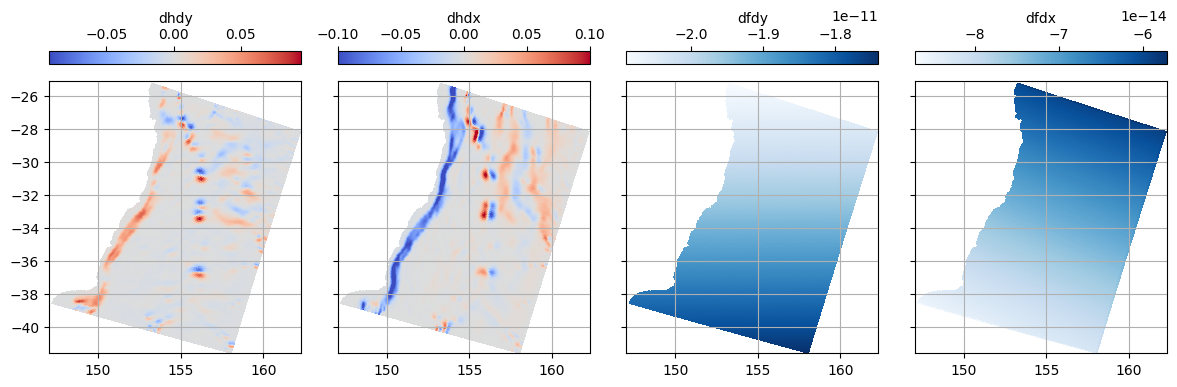

In [4]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 4))
c = axs[0].pcolor(lon_rho, lat_rho, dh_dN, cmap='coolwarm')
plt.colorbar(c, ax=axs[0], location='top', label='dhdy')
c = axs[1].pcolor(lon_rho, lat_rho, dh_dE, cmap='coolwarm', vmin=-.1, vmax=.1)
plt.colorbar(c, ax=axs[1], location='top', label='dhdx')

c = axs[2].pcolor(lon_rho, lat_rho, df_dN, cmap='Blues')
plt.colorbar(c, ax=axs[2], location='top', label='dfdy')
c = axs[3].pcolor(lon_rho, lat_rho, df_dE, cmap='Blues')
plt.colorbar(c, ax=axs[3], location='top', label='dfdx')
for ax in axs:
    ax.axis('equal'); ax.grid('on')
plt.tight_layout()


### $\beta$ effect

/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


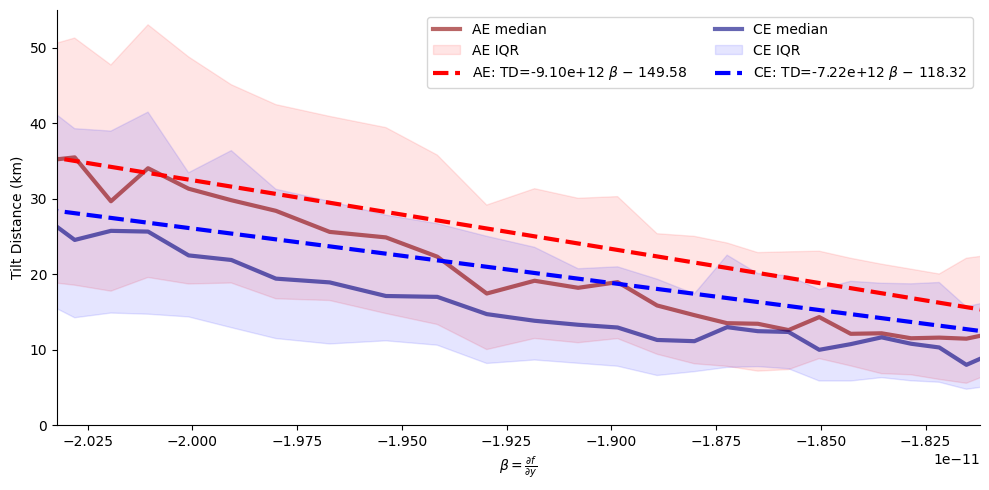

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['beta'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.beta.min(), df_all.beta.max()  # <-- set your limits 

mask_cap = (df_all.beta >= x_min) & (df_all.beta <= x_max)
N_all = df_all[mask_cap].beta.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['beta', 'TiltDis'])

    xval = df_masked['beta'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    Nmin, Nmax = xval.min(), xval.max()
    mask_reg = (xval >= Nmin) & (xval <= Nmax)

    if mask_reg.sum() > 2:
        xr = xval[mask_reg]
        yr = tilt[mask_reg]

        m, c, r, p, se = linregress(xr, yr)

        x_fit = np.linspace(Nmin, Nmax, 200)
        y_fit = m * x_fit + c

        ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
                label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')

# ax.plot([-1.5e-11, -2e-11], [20, 25])
# ax.plot([-2e-11, -2.15e-11], [25, 35])

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
lo, hi = np.percentile(df_eddies.beta, [10, 90])
ax.set_xlim(lo, hi)
ax.set_xlabel(r'$\beta=\frac{\partial f}{\partial y}$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()



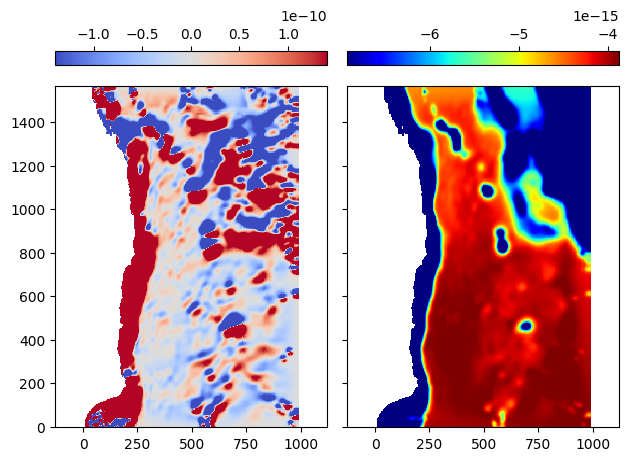

In [20]:
fig, axs = plt.subplots(1, 2, sharey=True)

lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
cent_abs = min(abs(lo), abs(hi))
pc = axs[0].pcolor(X_grid, Y_grid, topo_beta, cmap='coolwarm', vmin=-cent_abs, vmax=cent_abs)
fig.colorbar(pc, ax=axs[0], location='top')
axs[0].axis('equal')

lo, hi = np.nanpercentile(df_eddies.plan_beta, [10, 90])
pc = axs[1].pcolor(X_grid, Y_grid, plan_beta, cmap='jet', vmin=lo, vmax=hi)
fig.colorbar(pc, ax=axs[1], location='top')
axs[1].axis('equal')

plt.tight_layout()



#### Planetary Beta
$\beta_t=\frac{1}{H}f_y$


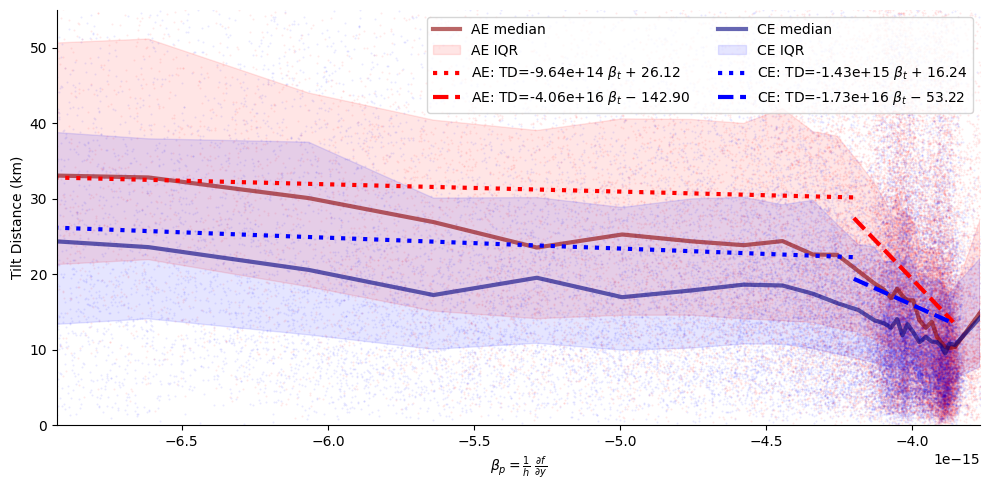

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['plan_beta'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.plan_beta.min(), df_all.plan_beta.max()  # <-- set your limits 

mask_cap = (df_all.plan_beta >= x_min) & (df_all.plan_beta <= x_max)
N_all = df_all[mask_cap].plan_beta.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['plan_beta', 'TiltDis'])

    xval = df_masked['plan_beta'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    split = -4.2e-15
    lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
    for l, (Nmin, Nmax) in enumerate(zip([lo, split],
                          [split, -3.86e-15])):
        mask_reg = (xval >= Nmin) & (xval <= Nmax)
    
        if mask_reg.sum() > 2:
            xr = xval[mask_reg]
            yr = tilt[mask_reg]
    
            m, c, r, p, se = linregress(xr, yr)
    
            x_fit = np.linspace(Nmin, Nmax, 200)
            y_fit = m * x_fit + c
    
            ax.plot(x_fit, y_fit, ':' if l==0 else'--', lw=3, color=styles[cyc]['fill'],
                    label=fr'{cyc}: TD={m:.2e} $\beta_t$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
lo, hi = np.nanpercentile(df_eddies.plan_beta, [10, 90])
ax.set_xlim(lo, bin_centers.max())
ax.set_xlabel(r'$\beta_p=\frac{1}{h}\ \frac{\partial f}{\partial y}$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


#### Topographic Beta
$\beta_t=-\frac{f}{H}h_y$


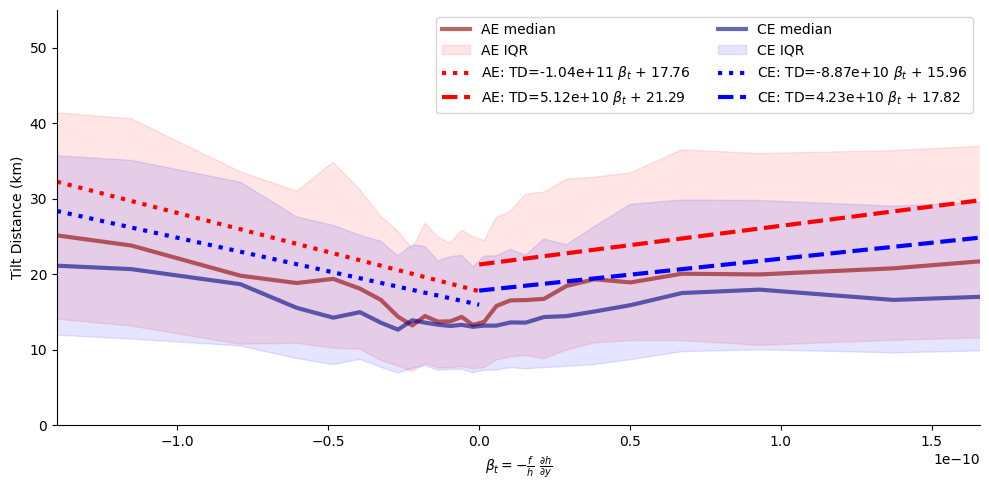

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['topo_beta'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.topo_beta.min(), df_all.topo_beta.max()  # <-- set your limits 

mask_cap = (df_all.topo_beta >= x_min) & (df_all.topo_beta <= x_max)
N_all = df_all[mask_cap].topo_beta.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['topo_beta', 'TiltDis'])

    xval = df_masked['topo_beta'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')

    # ------------------------------------------------------------
    # Linear regression on a chosen interval of xval
    # (keep this if you want restricted-slope fitting)
    # ------------------------------------------------------------
    lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
    for l, (Nmin, Nmax) in enumerate(zip([lo, 0],
                          [0, hi])):
        mask_reg = (xval >= Nmin) & (xval <= Nmax)
    
        if mask_reg.sum() > 2:
            xr = xval[mask_reg]
            yr = tilt[mask_reg]
    
            m, c, r, p, se = linregress(xr, yr)
    
            x_fit = np.linspace(Nmin, Nmax, 200)
            y_fit = m * x_fit + c
    
            ax.plot(x_fit, y_fit, ':' if l==0 else'--', lw=3, color=styles[cyc]['fill'],
                    label=fr'{cyc}: TD={m:.2e} $\beta_t$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
ax.set_xlim(lo, hi)
ax.set_xlabel(r'$\beta_t=-\frac{f}{h}\ \frac{\partial h}{\partial y}$')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


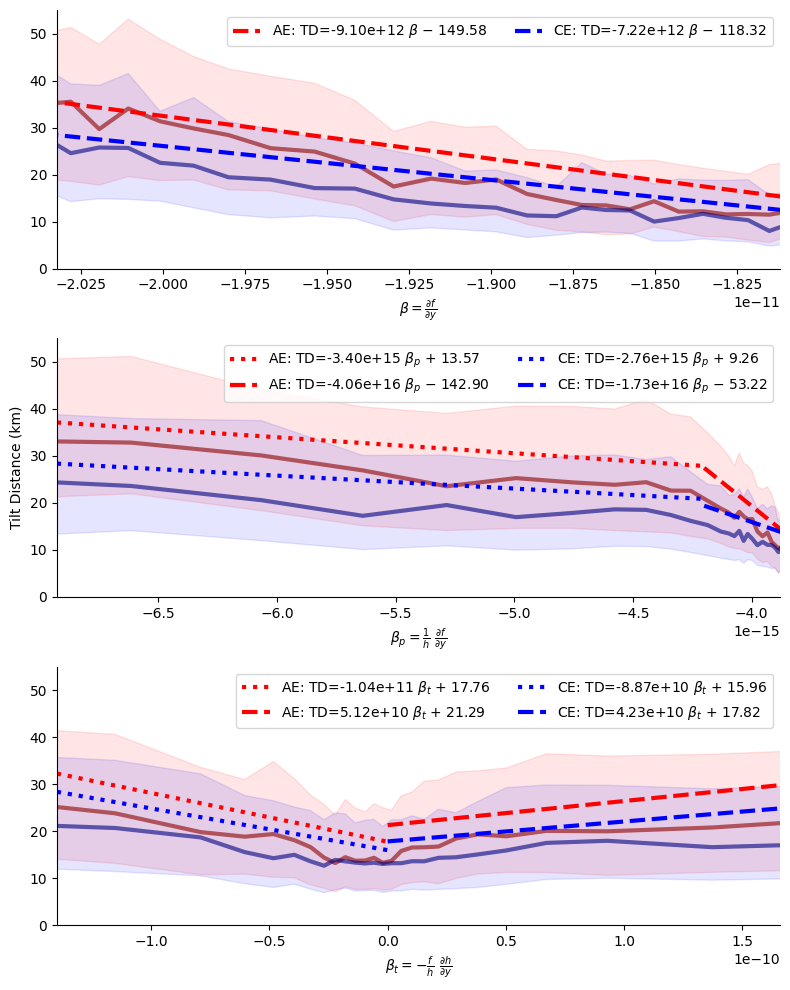

In [59]:
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=False)

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

def panel(ax, xcol, xlabel, legend_key, xlim=None, split=None, reg_hi_override=None, scatter=False):
    df_all = df_eddies.dropna(subset=[xcol])
    x_min, x_max = df_all[xcol].min(), df_all[xcol].max()

    nbins = 30
    bins = np.unique(np.quantile(df_all[xcol], np.linspace(0, 1, nbins + 1)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for cyc in ['AE', 'CE']:
        dfm = df_eddies[df_eddies.Cyc == cyc].dropna(subset=[xcol, 'TiltDis'])
        xval = dfm[xcol].values
        tilt = dfm['TiltDis'].values

        mask = (xval >= x_min) & (xval <= x_max)
        xval, tilt = xval[mask], tilt[mask]

        d = np.digitize(xval, bins)
        med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
        q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
        q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

        if scatter:
            ax.scatter(xval, tilt, s=1, alpha=0.08, color=styles[cyc]['fill'])

        ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
        ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.10)

        if split is None:
            m, c, *_ = linregress(xval, tilt)
            xf = np.linspace(xval.min(), xval.max(), 200)
            ax.plot(
                xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}'
            )
        else:
            lo, hi = np.nanpercentile(df_eddies[xcol], [10, 90])
            hi2 = reg_hi_override if reg_hi_override is not None else hi
        
            for l, (a, b) in enumerate(zip([lo, split], [split, hi2])):
                mask = (xval >= a) & (xval <= b)
                if mask.sum() > 2:
                    m, c, *_ = linregress(xval[mask], tilt[mask])
                    xf = np.linspace(a, b, 200)
                    sign_c = f'{c:+.2f}'
                    var = xlabel.split('=')[0].strip()
                    ax.plot(
                        xf, m*xf + c,
                        ':' if l == 0 else '--',
                        lw=3,
                        color=styles[cyc]['fill'],
                        label=fr'{cyc}: TD={m:.2e} {legend_key} '
                      fr'{"$-$" if c<0 else "$+$"} {abs(c):.2f}'
                    )
    ax.set_ylim(0, 55)
    if xlim is None:
        ax.set_xlim(*np.nanpercentile(df_eddies[xcol], [10, 90]))
    else:
        ax.set_xlim(*xlim)
    ax.legend(loc='upper right', ncol=2)
    ax.set_xlabel(xlabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

panel(
    axs[0],
    'beta',
    r'$\beta=\frac{\partial f}{\partial y}$',
    r'$\beta$'
)

panel(
    axs[1],
    'plan_beta',
    r'$\beta_p=\frac{1}{h}\ \frac{\partial f}{\partial y}$',
    r'$\beta_p$',
    split=-4.2e-15,
    reg_hi_override=-3.86e-15,
    scatter=False
)

panel(
    axs[2],
    'topo_beta',
    r'$\beta_t=-\frac{f}{h}\ \frac{\partial h}{\partial y}$',
    r'$\beta_t$',
    split=0.0
)

axs[1].set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()


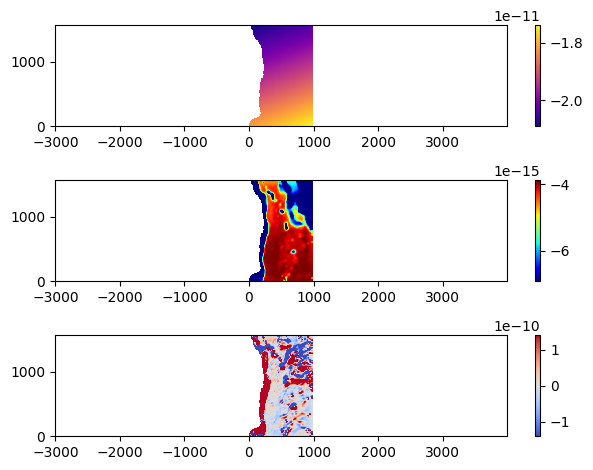

In [67]:

fig, axs = plt.subplots(3, 1, sharey=False)

lo, hi = np.nanpercentile(df_eddies.beta, [10, 90])
pc = axs[0].pcolor(X_grid, Y_grid, beta, cmap='plasma')
fig.colorbar(pc, ax=axs[0], location='right')
axs[0].axis('equal')

lo, hi = np.nanpercentile(df_eddies.plan_beta, [10, 90])
pc = axs[1].pcolor(X_grid, Y_grid, plan_beta, cmap='jet', vmin=lo, vmax=hi)
fig.colorbar(pc, ax=axs[1], location='right')
axs[1].axis('equal')

lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
cent_abs = min(abs(lo), abs(hi))
pc = axs[2].pcolor(X_grid, Y_grid, topo_beta, cmap='coolwarm', vmin=-cent_abs, vmax=cent_abs)
fig.colorbar(pc, ax=axs[2], location='right')
axs[2].axis('equal')

plt.tight_layout()


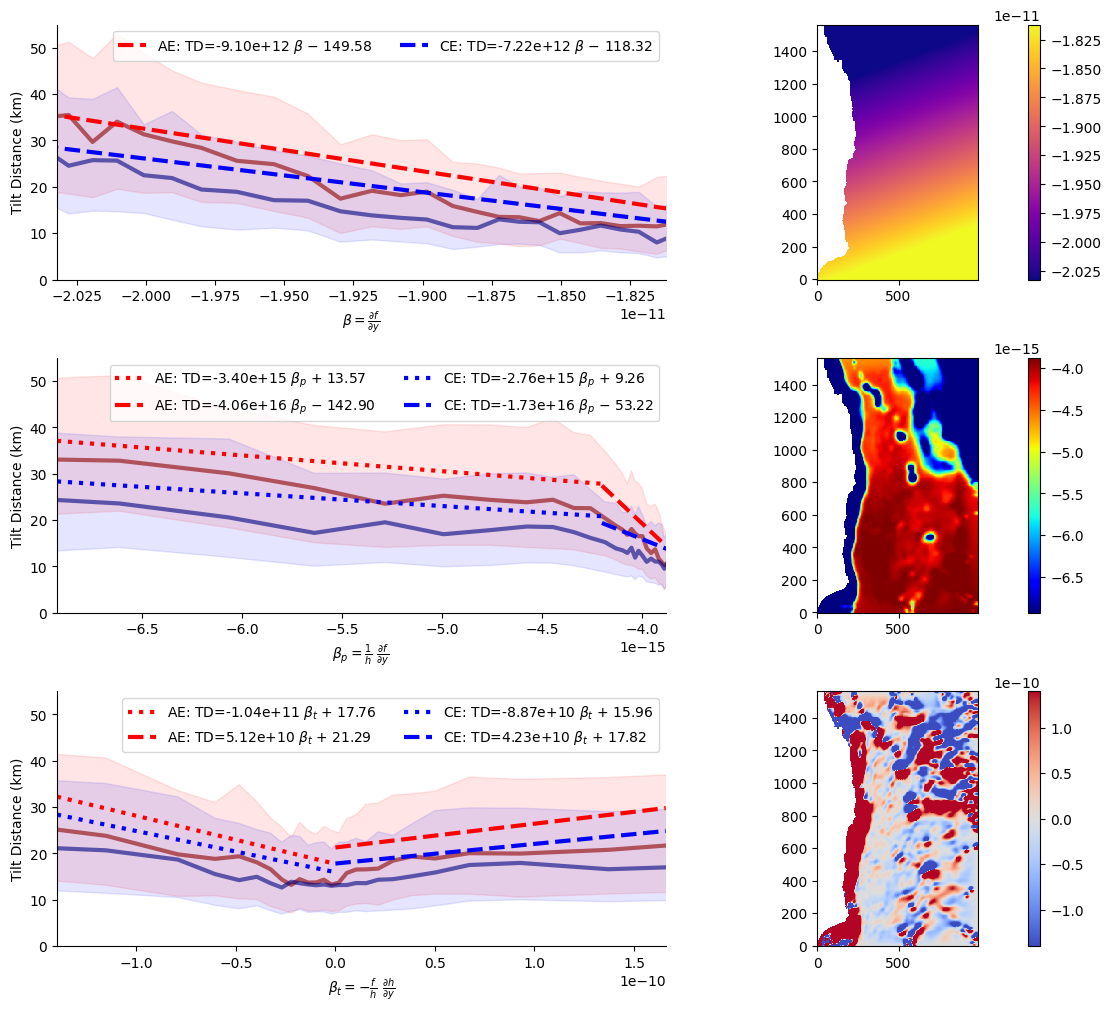

In [77]:
fig = plt.figure(figsize=(11, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[2.0, 1.0], hspace=0, wspace=0)

axs_L = [fig.add_subplot(gs[i, 0]) for i in range(3)]
axs_R = [fig.add_subplot(gs[i, 1]) for i in range(3)]

styles = {
    'AE': {'line': 'darkred', 'fill': 'red'},
    'CE': {'line': 'navy',    'fill': 'blue'}
}

def panel(ax, xcol, xlabel, legend_key, xlim=None, split=None, reg_hi_override=None, scatter=False):
    df_all = df_eddies.dropna(subset=[xcol])
    x_min, x_max = df_all[xcol].min(), df_all[xcol].max()

    nbins = 30
    bins = np.unique(np.quantile(df_all[xcol], np.linspace(0, 1, nbins + 1)))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for cyc in ['AE', 'CE']:
        dfm = df_eddies[df_eddies.Cyc == cyc].dropna(subset=[xcol, 'TiltDis'])
        xval = dfm[xcol].values
        tilt = dfm['TiltDis'].values

        mask = (xval >= x_min) & (xval <= x_max)
        xval, tilt = xval[mask], tilt[mask]

        d = np.digitize(xval, bins)
        med = [np.nanmedian(tilt[d == i]) for i in range(1, len(bins))]
        q25 = [np.nanquantile(tilt[d == i], .25) for i in range(1, len(bins))]
        q75 = [np.nanquantile(tilt[d == i], .75) for i in range(1, len(bins))]

        if scatter:
            ax.scatter(xval, tilt, s=1, alpha=0.08, color=styles[cyc]['fill'])

        ax.plot(bin_centers, med, lw=3, color=styles[cyc]['line'], alpha=.6)
        ax.fill_between(bin_centers, q25, q75, color=styles[cyc]['fill'], alpha=0.10)

        if split is None:
            m, c, *_ = linregress(xval, tilt)
            xf = np.linspace(xval.min(), xval.max(), 200)
            ax.plot(
                xf, m*xf + c, '--', lw=3, color=styles[cyc]['fill'],
                label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f}'
            )
        else:
            lo, hi = np.nanpercentile(df_eddies[xcol], [10, 90])
            hi2 = reg_hi_override if reg_hi_override is not None else hi

            for l, (a, b) in enumerate(zip([lo, split], [split, hi2])):
                mask = (xval >= a) & (xval <= b)
                if mask.sum() > 2:
                    m, c, *_ = linregress(xval[mask], tilt[mask])
                    xf = np.linspace(a, b, 200)
                    ax.plot(
                        xf, m*xf + c,
                        ':' if l == 0 else '--',
                        lw=3,
                        color=styles[cyc]['fill'],
                        label=fr'{cyc}: TD={m:.2e} {legend_key} {"$-$" if c<0 else "$+$"} {abs(c):.2f}'
                    )

    ax.set_ylim(0, 55)
    if xlim is None:
        ax.set_xlim(*np.nanpercentile(df_eddies[xcol], [10, 90]))
    else:
        ax.set_xlim(*xlim)

    ax.legend(loc='upper right', ncol=2)
    ax.set_xlabel(xlabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# =========================
# LEFT COLUMN — TD PANELS
# =========================
panel(
    axs_L[0],
    'beta',
    r'$\beta=\frac{\partial f}{\partial y}$',
    r'$\beta$'
)
axs_L[0].set_ylabel('Tilt Distance (km)')
panel(
    axs_L[1],
    'plan_beta',
    r'$\beta_p=\frac{1}{h}\ \frac{\partial f}{\partial y}$',
    r'$\beta_p$',
    split=-4.2e-15,
    reg_hi_override=-3.86e-15
)
axs_L[1].set_ylabel('Tilt Distance (km)')
panel(
    axs_L[2],
    'topo_beta',
    r'$\beta_t=-\frac{f}{h}\ \frac{\partial h}{\partial y}$',
    r'$\beta_t$',
    split=0.0
)

axs_L[2].set_ylabel('Tilt Distance (km)')


# =========================
# RIGHT COLUMN — MAPS
# =========================
lo, hi = np.nanpercentile(df_eddies.beta, [10, 90])
pc = axs_R[0].pcolor(X_grid, Y_grid, beta, cmap='plasma', vmin=lo, vmax=hi)
fig.colorbar(pc, ax=axs_R[0])
axs_R[0].set_aspect('equal', adjustable='box')

lo, hi = np.nanpercentile(df_eddies.plan_beta, [10, 90])
pc = axs_R[1].pcolor(X_grid, Y_grid, plan_beta, cmap='jet', vmin=lo, vmax=hi)
fig.colorbar(pc, ax=axs_R[1])
axs_R[1].set_aspect('equal', adjustable='box')

lo, hi = np.nanpercentile(df_eddies.topo_beta, [10, 90])
cent = min(abs(lo), abs(hi))
pc = axs_R[2].pcolor(
    X_grid, Y_grid, topo_beta,
    cmap='coolwarm', vmin=-cent, vmax=cent
)
fig.colorbar(pc, ax=axs_R[2])
axs_R[2].set_aspect('equal', adjustable='box')

plt.show()




/home/z5297792/myenv310/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


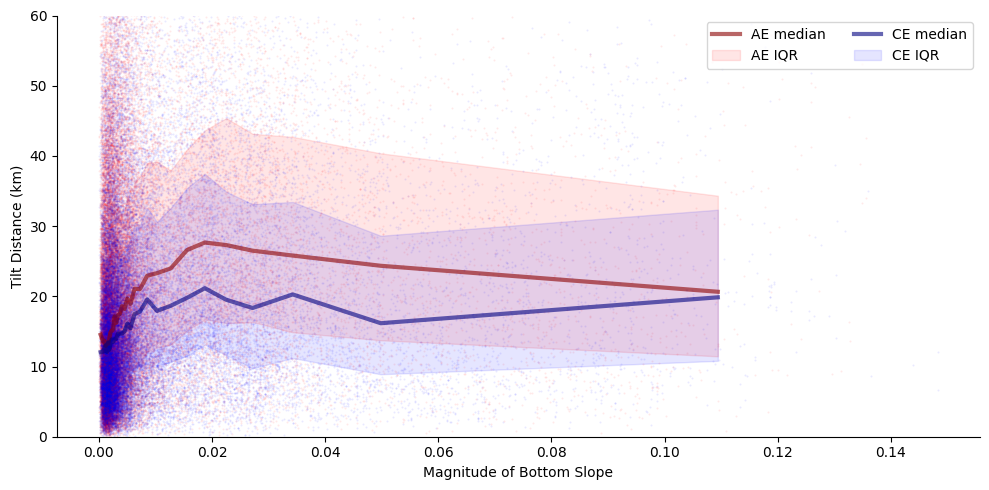

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['s'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.s.min(), df_all.s.max()  # <-- set your limits 

mask_cap = (df_all.s >= x_min) & (df_all.s <= x_max)
N_all = df_all[mask_cap].s.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['s', 'TiltDis'])

    xval = df_masked['s'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label=fr'{cyc}: TD={m:.2e} $\beta$ + {c:.2f}')

# ax.plot([-1.5e-11, -2e-11], [20, 25])
# ax.plot([-2e-11, -2.15e-11], [25, 35])

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 60)
# lo, hi = np.percentile(df_eddies.Ro, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Magnitude of Bottom Slope')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


In [34]:
df_eddies['shallow_slope'] = df_eddies.s.where(df_eddies.h < 4000)



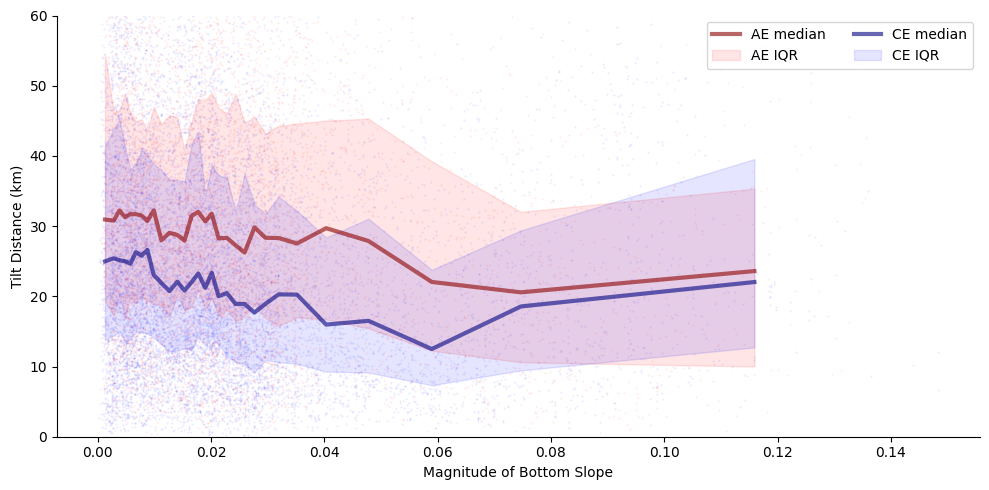

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['shallow_slope'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.shallow_slope.min(), df_all.shallow_slope.max()  # <-- set your limits 

mask_cap = (df_all.shallow_slope >= x_min) & (df_all.shallow_slope <= x_max)
N_all = df_all[mask_cap].shallow_slope.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['shallow_slope', 'TiltDis'])

    xval = df_masked['shallow_slope'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
               color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label=fr'{cyc}: TD={m:.2e} $\beta$ + {c:.2f}')

# ax.plot([-1.5e-11, -2e-11], [20, 25])
# ax.plot([-2e-11, -2.15e-11], [25, 35])

# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 60)
# lo, hi = np.percentile(df_eddies.Ro, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Magnitude of Bottom Slope')
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


In [ ]:
df_eddies['gamma'] = df_eddies.s / df_eddies.h

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['gamma'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.gamma.min(), df_all.gamma.max()  # <-- set your limits 

mask_cap = (df_all.gamma >= x_min) & (df_all.gamma <= x_max)
N_all = df_all[mask_cap].gamma.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['gamma', 'TiltDis'])

    xval = df_masked['gamma'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.gamma, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Normalised Topographic Slope $\frac{|\nabla h|}{h}$', fontsize=14)
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()


In [ ]:
df_eddies['gamma'] = df_eddies.f * df_eddies.s / df_eddies.h

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['gamma'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.gamma.min(), df_all.gamma.max()  # <-- set your limits 

mask_cap = (df_all.gamma >= x_min) & (df_all.gamma <= x_max)
N_all = df_all[mask_cap].gamma.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['gamma', 'TiltDis'])

    xval = df_masked['gamma'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.gamma, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Normalised Topographic Slope $\frac{f|\nabla h|}{h}$', fontsize=14)
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()




In [ ]:
df_eddies['gamma'] = df_eddies.beta * np.abs(dh_dN[df_eddies.ic, df_eddies.jc]) / df_eddies.h**2

fig, ax = plt.subplots(figsize=(10, 5))

styles = {
    'AE': {'line': 'darkred',  'fill': 'red'},
    'CE': {'line': 'navy',     'fill': 'blue'}
}

# ------------------------------------------------------------
# Build quantile-based bins using ALL 
# ------------------------------------------------------------
df_all = df_eddies.copy()
df_all = df_all.dropna(subset=['gamma'])

# x_min, x_max = .36e-14, 1.5e-14  # <-- set your limits 
x_min, x_max = df_all.gamma.min(), df_all.gamma.max()  # <-- set your limits 

mask_cap = (df_all.gamma >= x_min) & (df_all.gamma <= x_max)
N_all = df_all[mask_cap].gamma.values

nbins = 30
bins = np.quantile(N_all, np.linspace(0, 1, nbins + 1))
bins = np.unique(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# MAIN PLOT
# ------------------------------------------------------------
for cyc in ['AE', 'CE']:

    df_masked = df_eddies[df_eddies.Cyc == cyc].copy()
    df_masked = df_masked.dropna(subset=['gamma', 'TiltDis'])

    xval = df_masked['gamma'].values
    tilt = df_masked['TiltDis'].values

    # ------------------------------------------------------------
    # CAP THE DATA
    # ------------------------------------------------------------
    mask_cap = (xval >= x_min) & (xval <= x_max)
    xval = xval[mask_cap]
    tilt = tilt[mask_cap]

    # bin everything — no masking beyond the cap
    digitized = np.digitize(xval, bins)

    median = [np.nanmedian(tilt[digitized == i]) for i in range(1, len(bins))]
    q25    = [np.nanquantile(tilt[digitized == i], .25) for i in range(1, len(bins))]
    q75    = [np.nanquantile(tilt[digitized == i], .75) for i in range(1, len(bins))]

    # ax.scatter(xval, tilt, s=1, alpha=0.08, marker='.',
    #            color=styles[cyc]['fill'])

    ax.plot(bin_centers, median, lw=3, color=styles[cyc]['line'],
            alpha=.6, label=f'{cyc} median')

    ax.fill_between(bin_centers, q25, q75,
                    color=styles[cyc]['fill'], alpha=0.10, label=f'{cyc} IQR')


    # # ------------------------------------------------------------
    # # Linear regression on a chosen interval of xval
    # # (keep this if you want restricted-slope fitting)
    # # ------------------------------------------------------------
    # Nmin, Nmax = xval.min(), xval.max()
    # mask_reg = (xval >= Nmin) & (xval <= Nmax)

    # if mask_reg.sum() > 2:
    #     xr = xval[mask_reg]
    #     yr = tilt[mask_reg]

    #     m, c, r, p, se = linregress(xr, yr)

    #     x_fit = np.linspace(Nmin, Nmax, 200)
    #     y_fit = m * x_fit + c

    #     ax.plot(x_fit, y_fit, '--', lw=3, color=styles[cyc]['fill'],
    #             label = fr'{cyc}: TD={m:.2e} $\beta$ {"$-$" if c<0 else "$+$"} {abs(c):.2f}')


# ------------------------------------------------------------
# Formatting
# ------------------------------------------------------------
ax.set_ylim(0, 55)
# ax.set_xlim(-2e-11, 0)
# lo, hi = np.percentile(df_eddies.gamma, [10, 90])
# ax.set_xlim(lo, hi)
ax.set_xlabel(r'Normalised Topographic Slope $\frac{f|\nabla h|}{h}$', fontsize=14)
ax.set_ylabel('Tilt Distance (km)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right', ncol=2)

plt.tight_layout()
plt.show()